# SSH Eigenmodes

In this example we consider SSH model which Hamiltonian can be express in the following way,

$$H=-\sum_{ i} v (A_{i}^{\dagger}B_{i}+h.c.)-\sum_{j}w(A^{\dagger}_{i}A_{i+1}+B^{\dagger}_{i}B_{i+1}+h.c. ),$$
here $v$ ($w$) is the overlap integral between the atoms in unit cell (betwens cells).  

In [4]:
!pip install kwant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import kwant
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy as scp
import numpy as np
import scipy
from kwant.physics import dispersion
from numpy.linalg import eig

First of all we have to define our system. 

In [54]:
L = 50
# Building SSH model
def ssh_model(v=1, w=1, L=L, return_only_ham=1):

    syst = kwant.Builder()
    a = 1
    lat = kwant.lattice.chain(a)

    # Define the scattering region
    for n in range(L):
        syst[lat(n)] = 0

    # Left hopping
    for n in range(L):
        if n % 2:
            syst[lat(n - 1), lat(n)] = v

    # Right hopping
    for n in range(1, L):
        if not n % 2:
            syst[lat(n - 1), lat(n)] = w

    syst = syst.finalized()

    if return_only_ham:
        return syst.hamiltonian_submatrix(sparse=True)
    else:
        return syst.hamiltonian_submatrix(sparse=False)


In our case we put onsite equal to zero. In order to defne our system we establish diferent hoppings for odd and even sites. For even sites the Hamiltonian part discrebes intercells hoppings is
$$-\sum_{ i} v (A_{i}^{\dagger}B_{i}+h.c.)$$
while for odds we have got
$$-\sum_{j}w(A^{\dagger}_{i}A_{i+1}+B^{\dagger}_{i}B_{i+1}+h.c. )$$

The SSH is the simplest one dimensional model in which one can observed edge states. We can observed this on the folowing plot,


In [66]:
from   ipywidgets import *

def SSH_energy(v,w):
  w1,v1=eig(ssh_model(w=w, v=v, L=L, return_only_ham=0))
  plt.plot(np.arange(0,L,1),sorted(np.real(w1)),'.')


interact(SSH_energy,v=(0,1,0.1),w=(0,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='v', max=1.0), FloatSlider(value=0.0, description='w'…

One can observed that for $w>v$ there are two zero energy states which coresponds to edge states. The existance of such a states is topological protected. 

Now we want to plot energy spectrum as a function os hopping parameter $v$ when w is held constant. We have to identify each energy corespond to a given site. To this end, we used the following procedure. For a given $v$ we find all eigenvalues and eigenstates for every sites. Then we moved to another value of $v$ and do this same. Now to identife which eigenvalues corespond to this same site we chack for every eigenvector from the previous iteration gives us the bigest overlap (the bigest value of scalar product) with one of the state. The prosedure countinous for every value $v$.

In [92]:
def find_continuator(w: list, next_vectors: list) -> int:
    max_product = np.dot(w, next_vectors[0])
    max_index = 0

    for i in range(len(next_vectors)):
        product = np.abs(np.dot(w, next_vectors[i]))
        if product > max_product:
            max_product = product
            max_index = i
    return max_index


def plot_probability(k_tab: list ,eig_number: int,w,  show_unsorted=False) -> None:
    e_val_matrix = np.empty(shape=(len(k_tab), eig_number))
    e_vec_matrix = np.empty(shape=(len(k_tab), eig_number, L), dtype=complex)

    for i in range(len(k_tab)):
        v = k_tab[i]
        ham = ssh_model(v, w)
        e_val, e_vec = scipy.sparse.linalg.eigsh(
            ham, k=eig_number, sigma=0.01, which="LM", return_eigenvectors=True
        )

        e_val_matrix[i] = e_val
        for j in range(eig_number):
            e_vec_matrix[i, j] = e_vec[:, j]
            e_vec_matrix[i, j] = e_vec_matrix[i, j] / np.sqrt(
                np.dot(e_vec_matrix[i, j], e_vec_matrix[i, j])
            )

    for j in range(eig_number):
        pasek = [e_val_matrix[0, j]]
        wektory = [e_vec_matrix[0, j]]

        for i in range(0, len(k_tab) - 1):
            index = find_continuator(wektory[i], e_vec_matrix[i + 1])
            wektory.append(e_vec_matrix[i + 1, index])
            pasek.append(e_val_matrix[i + 1, index])

        plt.plot(k_tab, pasek, label=j)
        if show_unsorted:
            plt.scatter(k_tab, e_val_matrix[:, j], marker=".")

def SSH_spectrum_manipulate(w):
  plot_probability(k_tab=k,w=w, eig_number=energies_number)

k = np.linspace(0, 0.75, 50)  # Range of k we want to plot
energies_number = 45  # Number of energy bands to show

interact(SSH_spectrum_manipulate,w=(0.1,1,0.1));
plt.savefig("SSH_spectrum_sort.pdf")
plt.show()


interactive(children=(FloatSlider(value=0.5, description='w', max=1.0, min=0.1), Output()), _dom_classes=('wid…

<Figure size 432x288 with 0 Axes>

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


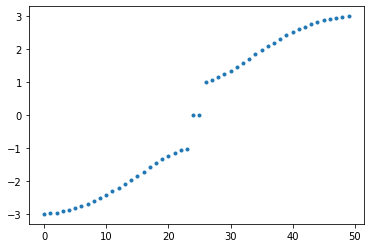

In [40]:
print(np.arange(0,L,1))
plt.plot(np.arange(0,L,1),sorted(w1),'.')